# 프로젝트 : 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기

아래 조건을 만족하는 함수를 만들어봅시다.

- 입력으로 이미지 경로를 받는다
- 정지 조건에 맞는 경우 "Stop", 아닌 경우 "Go"를 반환
- 정지 조건은 아래와 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px 이상인 경우

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [3]:
gpu = '0'
setup_gpu(gpu)

1 Physical GPUs, 1 Logical GPUs


In [4]:
model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

In [5]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()     

### 함수 만들기

In [6]:
def self_drive_assist(img_path, size_limit = 300):
    res = 'Go'
    img = read_image_bgr(img_path)
    
    draw = img.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(img, axis=0))
    
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        #print(box)
        if score < 0.5:
            break
        if label == 1: #사람이 있는 경우
            res = 'Stop'
            break
        if box[2] - box[0] > 300:
            res = 'Stop'
            break
    
    return res

테스트 해봅시다.

In [10]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
img_path2 = os.getenv("HOME") + '/aiffel/object_detection/test_set/stop_1.png' 

In [11]:
self_drive_assist(img_path)

'Go'

[593.291   173.88338 625.9446  205.3663 ]
[199.4168  137.29962 342.15326 235.6596 ]


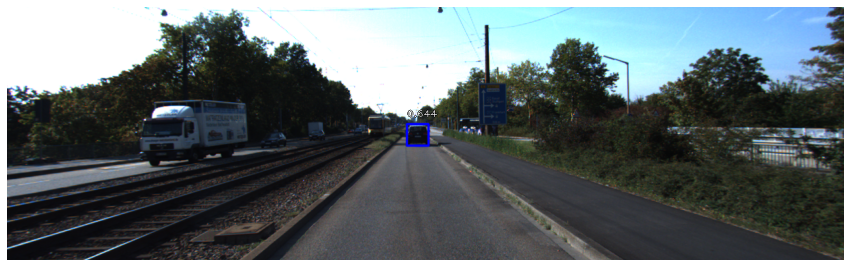

In [13]:
inference_on_image(model, img_path)

In [14]:
self_drive_assist(img_path2)

'Stop'

[773.28644 151.30258 846.1271  318.98914]
[770.2817  152.72287 851.6205  313.7208 ]


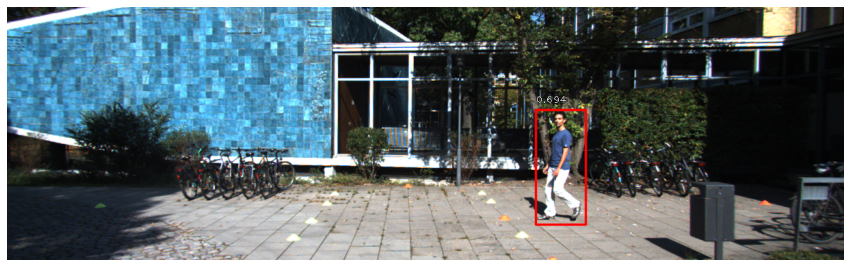

In [15]:
inference_on_image(model, img_path2)

## 2. 자율주행 시스템 평가하기

아래 test_system()을 통해 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가합니다.

In [16]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

80점입니다.
